In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
import gc
from scipy import sparse
%matplotlib inline

In [2]:
df_train = pd.read_csv('data/sales_train.csv.gz', compression='gzip')
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
df_test = pd.read_csv('data/test.csv.gz', compression='gzip')
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [4]:
df_item_bigcat = pd.read_csv('data/item_categories.csv')
l = list(df_item_bigcat.item_category_name)
l_cat = l
for ind in range(1,8): l_cat[ind] = 'Access'
for ind in range(10,18): l_cat[ind] = 'Consoles'
for ind in range(18,25): l_cat[ind] = 'Consoles Games'
for ind in range(26,28): l_cat[ind] = 'phone games'
for ind in range(28,32): l_cat[ind] = 'CD games'
for ind in range(32,37): l_cat[ind] = 'Card'
for ind in range(37,43): l_cat[ind] = 'Movie'
for ind in range(43,55): l_cat[ind] = 'Books'
for ind in range(55,61): l_cat[ind] = 'Music'
for ind in range(61,73): l_cat[ind] = 'Gifts'
for ind in range(73,79): l_cat[ind] = 'Soft'
df_item_bigcat['bigcat'] = l_cat
df_item_bigcat

,item_category_name,item_category_id,bigcat
0,PC - Гарнитуры/Наушники,0,PC - Гарнитуры/Наушники
1,Аксессуары - PS2,1,Access
2,Аксессуары - PS3,2,Access
3,Аксессуары - PS4,3,Access
4,Аксессуары - PSP,4,Access
5,Аксессуары - PSVita,5,Access
6,Аксессуары - XBOX 360,6,Access
7,Аксессуары - XBOX ONE,7,Access
8,Билеты (Цифра),8,Билеты (Цифра)
9,Доставка товара,9,Доставка товара


In [5]:
df_items = pd.read_csv('data/items.csv')
df_items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
df_item_bigcat = df_item_bigcat.merge(df_items)
df_item_bigcat.drop(['item_category_name', 'item_name'], axis=1, inplace=True)
df_item_bigcat.head()

,item_category_id,bigcat,item_id
0,0,PC - Гарнитуры/Наушники,5441
1,0,PC - Гарнитуры/Наушники,16255
2,0,PC - Гарнитуры/Наушники,16256
3,0,PC - Гарнитуры/Наушники,16257
4,1,Access,5606


In [7]:
df_train = df_train.merge(df_item_bigcat, 'left')
# df_train.loc[:, 'item_category_id'] = df_train.loc[:, 'item_category_id'].fillna(-1).astype(int)
print(df_train.shape)
df_train.head()

(2935849, 8)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,bigcat
0,02.01.2013,0,59,22154,999.00,1.0,37,Movie
1,03.01.2013,0,25,2552,899.00,1.0,58,Music
2,05.01.2013,0,25,2552,899.00,-1.0,58,Music
3,06.01.2013,0,25,2554,1709.05,1.0,58,Music
4,15.01.2013,0,25,2555,1099.00,1.0,56,Music


In [8]:
df_test = df_test.merge(df_item_bigcat, 'left')
# df_test.loc[:, 'item_category_id'] = df_test.loc[:, 'item_category_id'].fillna(-1).astype(int)
df_test.head()

,ID,shop_id,item_id,item_category_id,bigcat
0,0,5,5037,19,Consoles Games
1,1,5,5320,55,Music
2,2,5,5233,19,Consoles Games
3,3,5,5232,23,Consoles Games
4,4,5,5268,20,Consoles Games


In [9]:
junk_cats = [0,1,10,27,50,51,52]

In [10]:
print(set(df_train['item_category_id']) - set(df_test['item_category_id']))

print(set(df_test['item_category_id']) - set(df_train['item_category_id']))

zero_cnt_cats = set(df_train['item_category_id']) - set(df_test['item_category_id'])

{1, 4, 8, 10, 13, 14, 17, 18, 32, 39, 46, 48, 50, 51, 52, 53, 59, 66, 68, 80, 81, 82}
set()


In [11]:
drop_cats = junk_cats + list(zero_cnt_cats)
df_train = df_train.loc[~df_train['item_category_id'].isin(drop_cats)]
df_train.shape

(2904353, 8)

In [12]:
## Pivot by monht to wide format
df_train_piv = df_train.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_day',aggfunc='sum').fillna(0.0)
df_train_piv.head()

date_block_num    0     1    2    3    4    5    6    7    8    9  ...    24  \
shop_id item_id                                                    ...         
0       30       0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        31       0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        32       6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        33       3.0   3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        35       1.0  14.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   

date_block_num    25   26   27   28   29   30   31   32   33  
shop_id item_id                                               
0       30       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        31       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        32       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        33       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        35       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 34 columns]

In [13]:
df_train_piv.reset_index(inplace=True)

In [14]:
df_train_piv = df_train_piv.merge(df_item_bigcat, how="left", on="item_id")
df_train_piv.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,26,27,28,29,30,31,32,33,item_category_id,bigcat
0,0,30,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,Movie
1,0,31,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,Movie
2,0,32,6.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,Movie
3,0,33,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,Movie
4,0,35,1.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,Movie


In [15]:
# Encode Categories
from sklearn import preprocessing
number = preprocessing.LabelEncoder()
df_train_piv[['bigcat']] = number.fit_transform(df_train_piv.bigcat)

In [16]:
# df_train_piv['shop_id']= df_train_piv['shop_id'].astype('category')
# df_train_piv['item_id']= df_train_piv['item_id'].astype('category')
# df_train_piv['bigcat']= df_train_piv.bigcat.astype('category')
# df_train_piv['item_category_id']= df_train_piv.item_category_id.astype('category')

In [17]:
df_train_piv = df_train_piv[['shop_id', 'item_id', 'item_category_id','bigcat'] + list(range(34))]
df_train_piv.head()

,shop_id,item_id,item_category_id,bigcat,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,0,30,40,7,0.0,31.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,37,7,0.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,40,7,6.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,37,7,3.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,40,7,1.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# %load_ext autoreload
# %autoreload 2
from gatzzt import downcast_dtypes
df_train_piv = downcast_dtypes(df_train_piv)

# Preprocess categories

In [19]:
# clip
df_train_piv.iloc[:, 4:] = df_train_piv.iloc[:, 4:].clip(0, 20)
df_train_piv.head()

,shop_id,item_id,item_category_id,bigcat,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,0,30,40,7,0.0,20.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,37,7,0.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,40,7,6.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,37,7,3.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,40,7,1.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
df_cats = df_train_piv.iloc[:, :4]
df_cats.nunique()

shop_id                60
item_id             21174
item_category_id       60
bigcat                 15
dtype: int64

In [21]:
df_cats.loc[:, 'shop_item'] = df_cats['shop_id'].astype(str) + '_' + df_cats['item_id'].astype(str)
df_cats.loc[:, 'shop_category'] = df_cats['shop_id'].astype(str) + '_' + df_cats['item_category_id'].astype(str)
df_cats.loc[:, 'shop_bigcat'] = df_cats['shop_id'].astype(str) + '_' + df_cats['bigcat'].astype(str)
df_cats.head()

,shop_id,item_id,item_category_id,bigcat,shop_item,shop_category,shop_bigcat
0,0,30,40,7,0_30,0_40,0_7
1,0,31,37,7,0_31,0_37,0_7
2,0,32,40,7,0_32,0_40,0_7
3,0,33,37,7,0_33,0_37,0_7
4,0,35,40,7,0_35,0_40,0_7


In [22]:
# from sklearn.preprocessing import OneHotEncoder
# onehot_enc = OneHotEncoder()
# onehot_cols = df_cats.columns[df_cats.columns != 'item_id'].tolist()
# X_onehot = onehot_enc.fit_transform(df_cats.loc[:, onehot_cols])

# ###########
label_cols = df_cats.columns.tolist()
df_cats = df_cats.astype('category').astype(np.int32)
X_label = sparse.csr_matrix(df_cats.values)


In [23]:
df_months = df_train_piv.iloc[:, 4:]
df_months.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
df_months_diff = df_months.diff(axis=1)

In [58]:
def expanding_mean_encoding(df, group_cols, target_col=None):
    if not target_col:
        target_col = df.columns[-1]
    cumsum = df.groupby(group_cols)[target_col].cumsum() - df[target_col]
    cumcnt = df.groupby(group_cols)[target_col].cumcount()
    return (cumsum / cumcnt).to_dict()

In [59]:
def mean_encoding(df, group_cols, target_col=None):
    if not target_col:
        target_col = df.columns[-1]
    return df.groupby(group_cols)[target_col].mean().to_dict()

In [60]:
label_cols = ['item_id']
# map_dict = mean_encoding(df_train_piv.loc[:, label_cols + [32]], label_cols, 32)
map_dict = expanding_mean_encoding(df_train_piv.loc[:, label_cols + [32]], label_cols, 32)

X_label = sparse.csr_matrix(df_train_piv[label_cols[0]].map(map_dict))
X_label = X_label.transpose()

<class 'pandas.core.series.Series'>


# xgbost

In [25]:
param = {'max_depth':6, 
         'subsample':0.8,
         'colsample_bytree':0.8,
#          'min_child_weight':0.5,
         'eta':0.3, 
         'seed':1,
         'eval_metric':'rmse'}

In [26]:
def period_column_feats(X, period=12):
    n_col = X.shape[1]
    feats = []

    for i in range(12):
        cols = [i]
        j = 1
        while i + j * period < n_col:
            cols.append(i + j * period)
            j += 1
        feats.extend([X[:, cols].mean(axis=1), X[:, cols].max(axis=1), X[:, cols].min(
            axis=1), X[:, cols].std(axis=1), np.median(X[:, cols], axis=1)])
    return np.column_stack(feats)

In [27]:
n_months = 30
bsts = []

In [52]:
# train_cols = [-4, -3]
train_cols = [-2, -1]
# train_cols = [-2]
for train_col in train_cols:
    X_train = sparse.csr_matrix(df_months.iloc[:, train_col - n_months:train_col].values)
    X_train_diff = sparse.csr_matrix(df_months_diff.iloc[:, train_col - n_months:train_col].values)
    X_train = sparse.hstack((X_label, X_train_diff, X_train))

    y_train = df_months.iloc[:, train_col].values
#     y_train = df_months.iloc[:, train_col].values - df_months.iloc[:, train_col-1].values
    if train_col == train_cols[0]:
        X_train_cum, y_train_cum = X_train, y_train
    else:
        X_train_cum = sparse.vstack((X_train_cum, X_train))
        y_train_cum = np.concatenate((y_train_cum, y_train))
        
print(X_train_cum.shape)

(836838, 67)


In [55]:
val_col = train_cols[-1] + 1
val_col = train_cols[-1]
X_val = sparse.csr_matrix(df_months.iloc[:, val_col - n_months:val_col].values)
X_val_diff = sparse.csr_matrix(df_months_diff.iloc[:, val_col - n_months:val_col].values)
X_val = sparse.hstack((X_label, X_val_diff, X_val))
y_val = df_months.iloc[:, val_col].values
# y_val = df_months.iloc[:, val_col].values - df_months.iloc[:, val_col-1].values

In [56]:
xgbtrain = xgb.DMatrix(X_train_cum, y_train_cum)
xgbval = xgb.DMatrix(X_val, y_val)
watchlist  = [(xgbtrain,'train'), (xgbval,'val')]
bst = xgb.train(param, xgbtrain, num_boost_round=10,evals=watchlist, early_stopping_rounds=10)
bsts.append(bst)
del X_train, X_val, y_train, y_val, xgbtrain, xgbval
gc.collect()

[0]	train-rmse:0.812771	val-rmse:0.837029
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 10 rounds.
[1]	train-rmse:0.755596	val-rmse:0.781799
[2]	train-rmse:0.723605	val-rmse:0.751435
[3]	train-rmse:0.705699	val-rmse:0.73431
[4]	train-rmse:0.695412	val-rmse:0.724831
[5]	train-rmse:0.689167	val-rmse:0.718625
[6]	train-rmse:0.684641	val-rmse:0.714428
[7]	train-rmse:0.681198	val-rmse:0.710861
[8]	train-rmse:0.676907	val-rmse:0.704497
[9]	train-rmse:0.672108	val-rmse:0.69906


577

In [57]:
last_col = -1
X_last = sparse.csr_matrix(df_months.iloc[:, last_col - n_months:last_col].values)
X_last_diff = sparse.csr_matrix(df_months_diff.iloc[:, last_col - n_months:last_col].values)
X_last = sparse.hstack((X_label, X_last_diff, X_last))
y_last = df_months.iloc[:, last_col].values

In [58]:
xgblast = xgb.DMatrix(X_last)
# preds = bst.predict(xgblast, ntree_limit=bst.best_ntree_limit) + df_months.iloc[:, last_col-1].values
preds = bst.predict(xgblast, ntree_limit=bst.best_ntree_limit)

np.sqrt(mean_squared_error(y_last, preds))

0.69905967

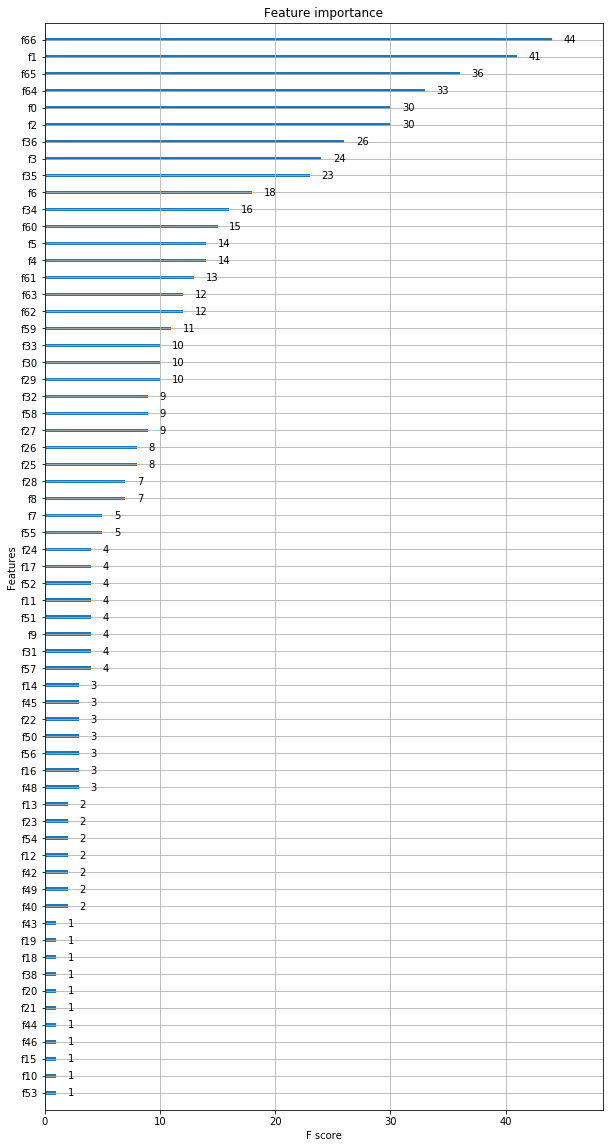

In [59]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

my_plot_importance(bst, figsize=(10, 20))

In [60]:
df_test = df_test.merge(df_train_piv[df_train_piv.columns[~df_train_piv.columns.isin(['item_category_id', 'bigcat'])]], how = "left", on = ["shop_id", "item_id"])
df_test[['bigcat']] = number.fit_transform(df_test.bigcat)
df_test.iloc[:, -34:] = df_test.iloc[:, -34:].fillna(0)
df_test.head()

,ID,shop_id,item_id,item_category_id,bigcat,0_x,1_x,2_x,3_x,4_x,...,24_y,25_y,26_y,27_y,28_y,29_y,30_y,31_y,32_y,33_y
0,0,5,5037,19,5,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,55,8,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,19,5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,23,5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,20,5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
df_cats.head()

,shop_id,item_id,item_category_id,bigcat,shop_item,shop_category,shop_bigcat
0,0,30,40,7,30,40,7
1,0,31,37,7,31,37,7
2,0,32,40,7,32,40,7
3,0,33,37,7,33,37,7
4,0,35,40,7,35,40,7


In [62]:
label_cols

['shop_id',
 'item_id',
 'item_category_id',
 'bigcat',
 'shop_item',
 'shop_category',
 'shop_bigcat']

In [63]:
df_test_label = df_test[['ID', 'shop_id', 'item_id']].merge(df_cats, how='left')
df_test_label.head()

,ID,shop_id,item_id,item_category_id,bigcat,shop_item,shop_category,shop_bigcat
0,0,5,5037,19.0,5.0,55037.0,519.0,55.0
1,1,5,5320,NaN,NaN,NaN,NaN,NaN
2,2,5,5233,19.0,5.0,55233.0,519.0,55.0
3,3,5,5232,23.0,5.0,55232.0,523.0,55.0
4,4,5,5268,NaN,NaN,NaN,NaN,NaN


In [64]:
X_test_label = sparse.csr_matrix(df_test_label[label_cols].values)
X_test_label.shape

(214200, 7)

In [65]:
X_test = sparse.csr_matrix(df_test.iloc[:, -n_months:].values)
X_test_diff = sparse.csr_matrix(df_test.iloc[:, -n_months:].diff(axis=1).values)
X_test = sparse.hstack((X_test_label, X_test_diff, X_test))

In [66]:
X_train_cum.shape

(836838, 67)

In [67]:
X_test.shape

(214200, 67)

In [68]:
xgbtest = xgb.DMatrix(X_test)

In [69]:
preds = []
for bst in bsts:
    preds.append(bst.predict(xgbtest, ntree_limit=bst.best_ntree_limit))

In [70]:
preds = np.column_stack(preds)
preds = np.mean(preds, axis=1)
preds = np.clip(preds, 0, 20)

In [75]:
# Normalize prediction to [0-20]
sub_df = pd.DataFrame({'ID':df_test.ID,'item_cnt_month': preds + 0.05 })
from datetime import datetime

sub_df.to_csv('submission/xgboost_{}.csv'.format(datetime.now().strftime('%Y-%m-%d %H-%M-%S')),index=False)

In [72]:
sub_df.head()

,ID,item_cnt_month
0,0,0.466702
1,1,0.094892
2,2,0.939034
3,3,0.166241
4,4,0.094892


# Random Forest

In [25]:
X = df_train_piv.iloc[:,  (df_train_piv.columns != 33)].values
y = df_train_piv.iloc[:, df_train_piv.columns == 33].values.ravel()
shopids = df_train_piv['shop_id'].values

In [41]:


# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
# train_index, val_index = next(skf.split(X, shopids))
# X_train, y_train = X[train_index], y[train_index]
# X_val, y_val = X[val_index], y[val_index]



# # X, y = sklearn.datasets.load_digits(10,True)
# X_train, X_val, y_train, y_val = train_test_split(X, y)

In [47]:
# from sklearn.ensemble import RandomForestRegressor

# n_estimators = 100
# rf = RandomForestRegressor(warm_start=True, criterion='mse', n_jobs=-1)

# train_scores = []
# val_scores = []
# for i in range(1, n_estimators + 1):
#     rf.set_params(n_estimators=i)
#     rf.fit(X_train, y_train)
#     train_pred = rf.predict(X_train)
#     val_pred = rf.predict(X_val)
#     train_score = np.sqrt(mean_squared_error(train_pred, y_train))
#     val_score = np.sqrt(mean_squared_error(val_pred, y_val))                    
#     print(i, train_score, val_score)

In [44]:
df_test = df_test_.copy()
df_test['shop_id']= df_test_.shop_id.astype('str')
df_test['item_id']= df_test_.item_id.astype('str')

df_test = df_test.merge(df_train_piv, how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
df_test.head()

,ID,shop_id,item_id,bigcat,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
d = dict(zip(df_test.columns[4:],list(np.array(list(df_test.columns[4:])) - 1)))
df_test  = df_test.rename(d, axis = 1)
df_test.head()

,ID,shop_id,item_id,bigcat,-1,0,1,2,3,4,...,23,24,25,26,27,28,29,30,31,32
0,0,5,5037,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
preds = rf.predict(df_test.iloc[:, (df_test.columns != 'ID') & (df_test.columns != -1)].values)

# Normalize prediction to [0-20]
preds = list(map(lambda x: min(20,max(x,0)), list(preds)))
sub_df = pd.DataFrame({'ID':df_test.ID,'item_cnt_month': preds })
from datetime import datetime

sub_df.to_csv('submission/xgboost_{}.csv'.format(datetime.now().strftime('%Y-%m-%d %H-%M-%S')),index=False)

In [ ]:
kaggle competitions submit -c competitive-data-science-final-project -f submission.csv -m "Message"